In [106]:
# processing
import pymysql.cursors
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scikitplot as skplt
from pandas import ExcelWriter
scaler = StandardScaler()
label = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline
# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.externals.six import StringIO
import pydot
# model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
# classificators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.externals import joblib
import IDF

In [107]:
# Подключиться к базе данных
def con():
    conn = pymysql.connect(
        host='10.100.0.100',
        port=33062,
        user='i.serov',
        password='7*&y9EkL',
        db='mysql')
    return conn

In [108]:
%%time
df = pd.read_sql('''
SELECT
c.credit_number,
if(((ifnull(cc2.total_payed,0)-ifnull(cc1.total_payed,0))/initial_amount>0.1),0,1) as is_bad,
c.initial_amount,
    #if(cc2.total_payed <= 0.1 * c.initial_amount, 1, 0) AS is_bad,
    #1 = send to collection, 0 = do not send
    #if(cc2.total_payed = 0, 1, 0)                       AS is_very_bad,
    datediff(w.next_income_date, c.date_requested)      AS days_bef_sal,
    cc1.*,
    p_d.*,
    w.*,
    i.*,
    b.is_filled_idv,
    b.is_reset_bank_account,
    b.has_online_banking

 
  ,datediff(date(c.date_requested),date(b.creation_date)) as days_since_bor_creation

  
  ,(select count(*) from moneyman_es.credit cin
    where cin.borrower_id = c.borrower_id
    and cin.status = 'CANCELLED'
    and cin.id < c.id) as prev_canc_appl_cnt

 
  ,(select count(*) from moneyman_es.credit cin
    where cin.borrower_id = c.borrower_id
    and cin.status = 'CANCELLED'
    and cin.id < c.id
    and DATE(cin.date_requested) >= DATE(c.date_requested) - interval 1 month) as lw_prev_canc_appl_cnt

  
  ,(select datediff(DATE(c.date_requested),DATE(cin.date_requested)) from moneyman_es.credit cin
    where cin.borrower_id = c.borrower_id
    and cin.id < c.id
    and cin.status = 'CANCELLED'
    order by cin.id DESC
    limit 1
   ) as days_from_last_cancelled

 
  ,(select c.initial_amount/cin.initial_amount
   from moneyman_es.credit cin
   where cin.id < c.id
   and cin.borrower_id = c.borrower_id
   order by cin.id DESC
   limit 1) as issued_amnt_t_prev_appl_amnt


FROM moneyman_es.credit_calculations cc1
    LEFT JOIN moneyman_es.credit c
        ON cc1.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc2
        ON cc1.credit_id = cc2.credit_id AND cc1.calculation_date + INTERVAL 30 DAY = cc2.calculation_date
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.personal_data p_d
        ON b.personal_data_id = p_d.id
    LEFT JOIN moneyman_es.iovation i
        ON c.id = i.credit_id
    LEFT JOIN (SELECT
                   sum(succ_DD)   AS succ_DD,
                   sum(unsucc_DD) AS unsucc_DD,
                   credit_id
               FROM (
                        SELECT
                            if(recurrent IS TRUE AND result_code = 0, 1, 0)  AS succ_DD,
                            if(recurrent IS TRUE AND result_code <> 0, 1, 0) AS unsucc_DD,
                            cp.*
                        FROM moneyman_es.payment cp LEFT JOIN moneyman_es.credit_calculations cc
                                ON cp.credit_id = cc.credit_id
                            LEFT JOIN moneyman_es.credit c
                                ON cc.credit_id = c.id
                        WHERE cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
                              cp.transaction_date < cc.calculation_date  AND
                              c.date_requested > '2017-01-01'
                              AND cc.credit_id IN (
                            SELECT credit_id
                            FROM moneyman_es.credit_calculations
                            WHERE status_days_count = 20 AND expired_days_count = 20)
                        ORDER BY id DESC) q
               GROUP BY credit_id) qq1
        ON cc1.credit_id = qq1.credit_id
    LEFT JOIN (SELECT
                   sum(succ_DD)   AS succ_DD,
                   sum(unsucc_DD) AS unsucc_DD,
                   credit_id
               FROM (
                        SELECT
                            if(recurrent IS TRUE AND result_code = 0, 1, 0)  AS succ_DD,
                            if(recurrent IS TRUE AND result_code <> 0, 1, 0) AS unsucc_DD,
                            cp.*
                        FROM moneyman_es.payment cp LEFT JOIN moneyman_es.credit_calculations cc
                                ON cp.credit_id = cc.credit_id
                            LEFT JOIN moneyman_es.credit c
                                ON cc.credit_id = c.id
                        WHERE cc.status_days_count = 50 AND cc.status = 'EXPIRED' AND
                              cp.transaction_date < cc.calculation_date  AND
                              c.date_requested > '2017-01-01'
                              AND cc.credit_id IN (
                            SELECT credit_id
                            FROM moneyman_es.credit_calculations
                            WHERE status_days_count = 50 AND expired_days_count = 50)
                        ORDER BY id DESC) q
               GROUP BY credit_id) qq2
        ON cc1.credit_id = qq2.credit_id
WHERE cc1.status_days_count = 20 AND cc1.status = 'EXPIRED' AND
      cc1.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01' AND cc1.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20);
''', con=con())
df['age'] = 2018 - df['birthday'].apply(lambda x: x.year)
df1 = df.copy()
#df = df.sample(frac=1).reset_index(drop=True)

Wall time: 20.2 s


In [109]:
df.is_bad.value_counts()

1    16964
0     2406
Name: is_bad, dtype: int64

In [110]:
%%time
# SMS-Notifitcations
sms = pd.read_sql('''
SELECT
    cc.credit_id,
    n.*
FROM moneyman_es.notification_sms n LEFT JOIN moneyman_es.borrower b
        ON n.borrower_id = b.id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE n.date_sent < cc.calculation_date and 
cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
      cc.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01'
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20);
''', con=con())
sms1 = sms.copy()

Wall time: 1min 12s


In [111]:
%%time
# Payments
payments = pd.read_sql('''
SELECT cp.*
FROM moneyman_es.credit_payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cp.payment_date < cc.calculation_date 
and cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
      cc.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01'
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20);
''', con=con())
payments1 = payments.copy()

Wall time: 2.19 s


In [112]:
%%time
# Payments
DD = pd.read_sql('''
SELECT sum(succ_DD) as succ_DD, sum(unsucc_DD) as unsucc_DD, credit_id
FROM (
SELECT
    if(recurrent IS TRUE AND result_code = 0, 1, 0) AS succ_DD,
    if(recurrent IS TRUE AND result_code <> 0, 1, 0) AS unsucc_DD,
    cp.*
FROM moneyman_es.payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
      cc.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01' and
      cp.transaction_date < cc.calculation_date
      AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20)
ORDER BY id DESC) q
GROUP BY credit_id
''', con=con())

Wall time: 6.36 s


In [113]:
%%time
# Logins on site
logins = pd.read_sql('''
SELECT
    cc.credit_id,
    ul.*
FROM moneyman_es.user_login_history ul LEFT JOIN moneyman_es.borrower b
        ON ul.user_id = b.user_account_id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
      cc.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01' and
ul.login_date < cc.calculation_date 
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20);
''', con=con())
logins1 = logins.copy()

Wall time: 17.2 s


In [114]:
%%time
# Collectors Calls
colcalls = pd.read_sql('''
SELECT
    coc.credit_id,
    cac.*
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.status_days_count = 20 AND cc.status = 'EXPIRED' AND
      cc.total_payed <= 0.25 * c.initial_amount AND
      c.date_requested > '2017-01-01' and c.date_requested < '2018-04-01' and cac.call_date < cc.calculation_date 
AND cc.credit_id IN (
    SELECT credit_id
    FROM moneyman_es.credit_calculations
    WHERE status_days_count = 20 AND expired_days_count = 20);
''', con=con())
colcalls1 = colcalls.copy()

Wall time: 10.6 s


# Preprocessing

In [115]:
# SMS Preprocessing
sms = sms[['credit_id', 'date_sent', 'sms_provider_status', 'sms_status', 'sms_message_type', 'sms_sender_type']]
sms_pivot1 = sms.pivot_table(index = ['credit_id'], columns = 'sms_message_type', aggfunc='size').reset_index().fillna(0)
sms_pivot1['count_all_sms'] = sms.groupby('credit_id').agg({'sms_status': 'count'}).reset_index().sms_status
sms_pivot2 = sms.pivot_table(index=['credit_id'], columns='sms_status',
                             aggfunc='size').reset_index().fillna(0).drop('credit_id', axis=1)
sms = pd.concat([sms_pivot1, sms_pivot2], axis=1)

In [116]:
# logins
logs2 = logins.groupby('credit_id').agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_logins'})
logs2['max_log_date'] = logins.groupby('credit_id').agg(
    {'login_date': 'max'}).reset_index().drop('credit_id', axis=1)
logins = logs2.copy()

In [117]:
# payments
payments = payments[['credit_id', 'amount', 'days_between_payments', 'payment_source',
                     'percent_to_pay', 'goal', 'goal_amount', 'collector_id', 'is_recurrent']]
p1 = payments.groupby('credit_id').agg({'is_recurrent': 'sum'}).reset_index().fillna(0)
p1['count_payments'] = payments.groupby('credit_id').agg({'goal': 'count'}).reset_index().fillna(0).rename(columns={'goal': 'count_payments'}).drop(
    'credit_id', axis=1)
p1['sum_p_amount'] = payments.groupby('credit_id').agg({'amount': 'sum'}).reset_index().fillna(0).rename(columns={'amount': 'sum_p_amount'}).drop(
    'credit_id', axis=1)
p1['max_p_amount'] = payments.groupby('credit_id').agg({'amount': 'max'}).reset_index().fillna(0).rename(columns={'amount': 'max_p_amount'}).drop(
    'credit_id', axis=1)
p1['min_p_amount'] = payments.groupby('credit_id').agg({'amount': 'min'}).reset_index().fillna(0).rename(columns={'amount': 'min_p_amount'}).drop(
    'credit_id', axis=1)
payments = p1

#### Collectors calls

In [118]:
# BIG SHAPE
colcalls['diff_status'] = colcalls['old_contact_status'] + '->' + colcalls['new_contact_status']
cc1 = colcalls.pivot_table(index=['credit_id'], columns='diff_status', aggfunc='size').reset_index().fillna(0)
c1 = colcalls.groupby('credit_id').agg({'duration': 'min'}).reset_index().fillna(0).rename(columns={'duration': 'min_duration'}).drop('credit_id', axis=1)
c1['max_duration'] = colcalls.groupby('credit_id').agg({'duration': 'max'}).reset_index().fillna(0).rename(columns={'duration': 'max_duration'}).drop('credit_id', axis=1)
c1['sum_duration'] = colcalls.groupby('credit_id').agg({'duration': 'sum'}).reset_index().fillna(0).rename(columns={'duration': 'sum_duration'}).drop('credit_id', axis=1)
colcs = pd.concat([cc1[['credit_id','NOT_DEFINED->PHONE_NO_ANSWER', 'PHONE_NO_ANSWER->PHONE_NO_ANSWER']], c1], axis=1)

#### Df preprocessing

In [119]:
df.drop(['id', 'bonus_amount', 'calculation_date', 'status', 'prev_credit_calculation_id', 'first_name', 
         'full_name', 'first_last_name','maritalStatus_old','second_last_name', 'habitation_old', 'version',
         'payments_loans_currency', 'timezone_utc_offset','job_time', 'next_income_date', 'tel_number',
       'tel_number_extention','income_frequency_id','position', 'next_income_date2', 'tel_number_extension',
       'passport_identification_number', 'employer', 'amount_additional', 'currency_id_additional',
         'current_scope_time', 'employee_company_id', 'experience_in_current_place', 'general_experience',
       'spouse_mobile_number', 'spouse_full_name', 'phone_in_common_format', 'phone_in_common_format_crypt', 
         'id', 'date', 'response_date', 'trackingnumber', 'endblackbox', 'faultstring','device_flash_version',
       'device_alias', 'device_firstseen','device_browser_version', 'device_browser_charset',
       'device_browser_configured_lang', 'device_browser_lang','ipaddress', 'ipaddress_org', 'ipaddress_isp',
       'ipaddress_proxy', 'ipaddress_loc_city', 'ipaddress_loc_country_code',
       'ipaddress_loc_country', 'ipaddressLoc_region', 'realipaddress_source', 'realipaddress_org', 'realipaddress_isp',
       'realipaddress_proxy', 'realipaddress_loc_city', 'realipaddress_loc_country_code','ipaddress_loc_lat',
       'realipaddress_loc_country', 'realipaddress_loc_region','borrower_id', 'birthday', 'credit_id_2', 'result',
         'ipaddress_loc_lng', 'is_filled_idv', 'realipaddress', 'realipaddress_loc_lat', 'realipaddress_loc_lng',
         'is_reset_bank_account', 'has_online_banking','ruleset_rulesmatched', 'ruleset_score'
         ], axis=1, inplace=True)

In [120]:
df.columns

Index(['credit_number', 'is_bad', 'initial_amount', 'days_bef_sal',
       'credit_id', 'expired_debt', 'main_debt', 'main_debt_repaid',
       'payments_amount', 'penalty_charge', 'penalty_debt', 'penalty_repaid',
       'percent_charge', 'percent_debt', 'percent_repaid', 'status_days_count',
       'status_reason_code', 'total_debt', 'overpaid', 'total_payed',
       'commission_amount', 'forgiven_amount', 'expired_days_count',
       'dependants_count', 'maritalStatus', 'sex', 'habitation',
       'payments_loans', 'ID_document_type', 'credit_purpose_id', 'amount',
       'currency_id', 'education', 'employment_id', 'industry_id', 'post_id',
       'full_job_time', 'family_income', 'reason', 'device_new',
       'device_screen', 'device_type', 'device_os', 'device_tz',
       'device_js_enabled', 'device_flash_enabled', 'device_flash_installed',
       'device_flash_storage_enabled', 'device_flash_cookie_enabled',
       'device_browser_type', 'device_trust_score',
       'registrat

In [121]:
df.columns = ['credit_number', 'is_bad','initial_amount', 'days_bef_sal', 'credit_id', 'expired_debt',
       'main_debt', 'main_debt_repaid', 'payments_amount', 'penalty_charge',
       'penalty_debt', 'penalty_repaid', 'percent_charge', 'percent_debt',
       'percent_repaid', 'status_days_count', 'status_reason_code',
       'total_debt', 'overpaid', 'total_payed', 'commission_amount',
       'forgiven_amount', 'expired_days_count', 'dependants_count',
       'maritalStatus', 'sex', 'habitation', 'payments_loans',
       'ID_document_type', 'credit_purpose_id', 'amount', 'currency_id',
       'education', 'employment_id', 'industry_id', 'post_id', 'full_job_time',
       'family_income', 'reason', 'device_new', 'device_screen', 'device_type',
       'device_os', 'device_tz', 'device_js_enabled', 'device_flash_enabled',
       'device_flash_installed', 'device_flash_storage_enabled',
       'device_flash_cookie_enabled', 'device_browser_type',
       'device_trust_score',    'registration_check_matchstatus', 'registration_check_measureofchange',
        'credit_id_2',  'days_since_bor_creation', 'prev_canc_appl_cnt',
       'lw_prev_canc_appl_cnt', 'days_from_last_cancelled',
       'issued_amnt_t_prev_appl_amnt', 'age']

In [122]:
'''df.drop(['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ], axis=1, inplace=True)''';

In [123]:
#with sms
#X = pd.merge(colcs, pd.merge(logins, pd.merge(payments, pd.merge(sms, df, how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id')

In [124]:
X = pd.merge(colcs, pd.merge(logins, pd.merge(payments, df, how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id')

In [125]:
X = pd.merge(X, DD, how = 'left', on = 'credit_id')
#X.drop(['PREPARED_FOR_SENDING'], axis=1, inplace=True)

In [126]:
#X.columns

In [127]:
cat_vars = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ]
for i in cat_vars:
    X[i] = label.fit_transform(X[i].astype(str))
    #joblib.dump(label, 'ES_CL_%s.pkl'% i)

In [128]:
X.fillna(-1, inplace=True)
X.device_new = X.device_new.astype(int)

In [129]:
y = X.is_bad
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [130]:
#df_train[df_train.credit_number!=1].is_bad.value_counts()

In [131]:
def downsample(df):
    df_suc = df[df.is_bad==0]
    df_fail = df[df.is_bad==1]
    df_fail_ds = resample(df_fail,replace=False,n_samples=2000,random_state=123)
    df_downsampled = pd.concat([df_fail_ds, df_suc])
    df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
    return df_downsampled
df_train = downsample(df_train)
#df = df_train.copy()

In [132]:
y_train = df_train.is_bad
y_test = df_test.is_bad
X_train = df_train.drop(['is_bad', 'credit_id', 'credit_id_2', 'max_log_date'], axis=1)
X_test = df_test.drop(['is_bad', 'credit_id', 'credit_id_2', 'max_log_date'], axis=1)

In [133]:
%%time
clf2 = RandomForestClassifier(n_estimators=300, random_state = 1).fit(X_train, y_train)

Wall time: 2.11 s


ROC_AUC:   0.5603042325821378
Gini:      0.12060846516427559
F1_score:  0.506515729893379
Log_loss:  9.508729848212884


Classification_report: 
              precision    recall  f1-score   support

          0       0.89      0.16      0.28      4381
          1       0.34      0.96      0.51      2012

avg / total       0.72      0.41      0.35      6393



Weight,Feature
0.0527 ± 0.0386,unsucc_DD
0.0442 ± 0.0193,days_bef_sal
0.0410 ± 0.0218,count_logins
0.0406 ± 0.0171,age
0.0399 ± 0.0271,sum_duration
0.0388 ± 0.0156,amount
0.0333 ± 0.0152,payments_loans
0.0333 ± 0.0139,device_os
0.0327 ± 0.0192,days_since_bor_creation
0.0322 ± 0.0190,PHONE_NO_ANSWER->PHONE_NO_ANSWER


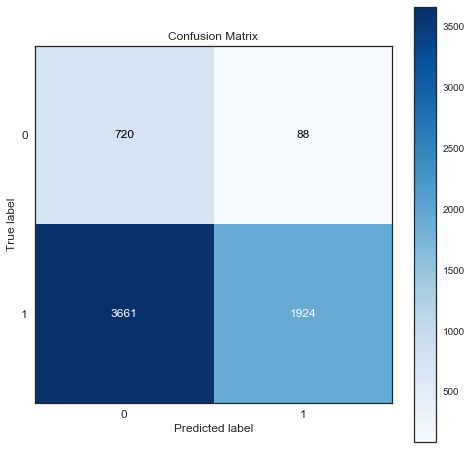

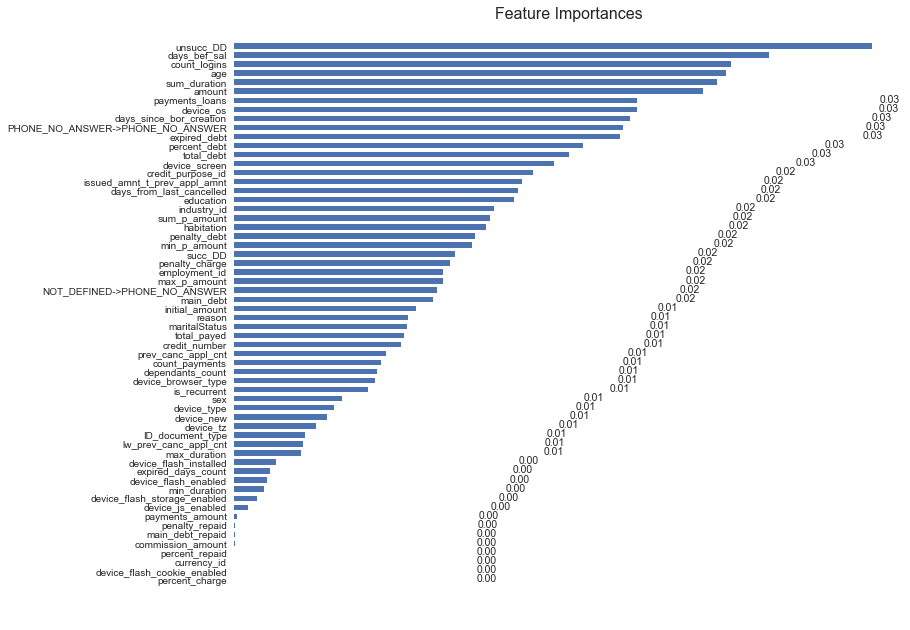

In [137]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.67, feat_to_show=60)

In [138]:
joblib.dump(clf2, 'ES_CL_model_v1.pkl');

ROC_AUC:   0.5666997428073465
Gini:      0.13339948561469295
F1_score:  0.5299766415779912
Log_loss:  9.02788769859405


Classification_report: 
              precision    recall  f1-score   support

          0       0.90      0.17      0.29      4272
          1       0.37      0.96      0.53      2121

avg / total       0.72      0.43      0.37      6393



Weight,Feature
0.0419 ± 0.0379,unsucc_DD
0.0352 ± 0.0180,days_bef_sal
0.0349 ± 0.0215,count_logins
0.0323 ± 0.0222,sum_duration
0.0321 ± 0.0159,amount
0.0312 ± 0.0138,age
0.0285 ± 0.0182,PHONE_NO_ANSWER->PHONE_NO_ANSWER
0.0273 ± 0.0125,payments_loans
0.0272 ± 0.0130,expired_debt
0.0263 ± 0.0125,device_os


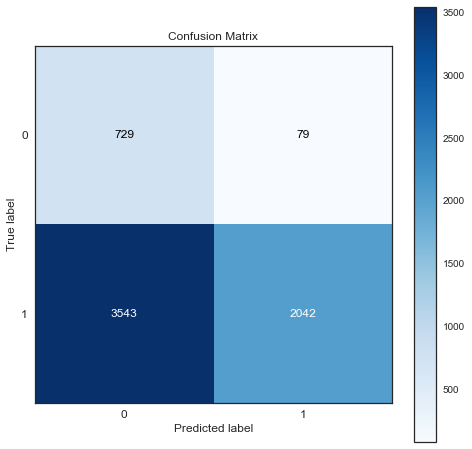

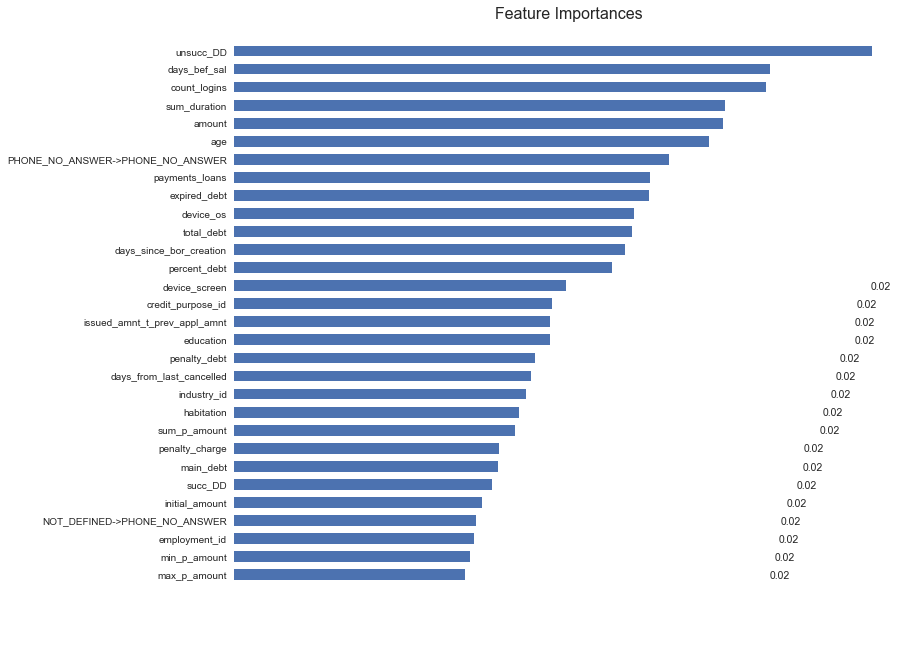

In [63]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.67)

In [254]:
%%time
#clf3 = RandomForestClassifier(n_estimators=200, random_state = 1, class_weight='balanced').fit(X_train, y_train)

Wall time: 0 ns


In [266]:
y_test = df_test[df_test.credit_number==1].is_bad
X_test = df_test[df_test.credit_number==1].drop(['is_bad', 'credit_id', 'credit_id_2', 'max_log_date'], axis=1)

ROC_AUC:   0.567614328834216
Gini:      0.13522865766843206
F1_score:  0.6841249774245981
Log_loss:  6.063488767523455


Classification_report: 
              precision    recall  f1-score   support

          0       0.85      0.16      0.28      2025
          1       0.53      0.97      0.68      1951

avg / total       0.69      0.56      0.48      3976



Weight,Feature
0.0350 ± 0.0387,unsucc_DD
0.0250 ± 0.0245,count_all_sms
0.0250 ± 0.0156,days_bef_sal
0.0242 ± 0.0124,age
0.0238 ± 0.0121,amount
0.0225 ± 0.0198,DELIVERED
0.0223 ± 0.0130,count_logins
0.0222 ± 0.0160,sum_duration
0.0204 ± 0.0397,succ_DD
0.0202 ± 0.0125,expired_debt


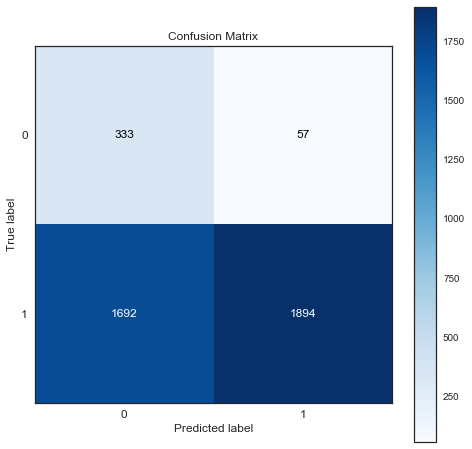

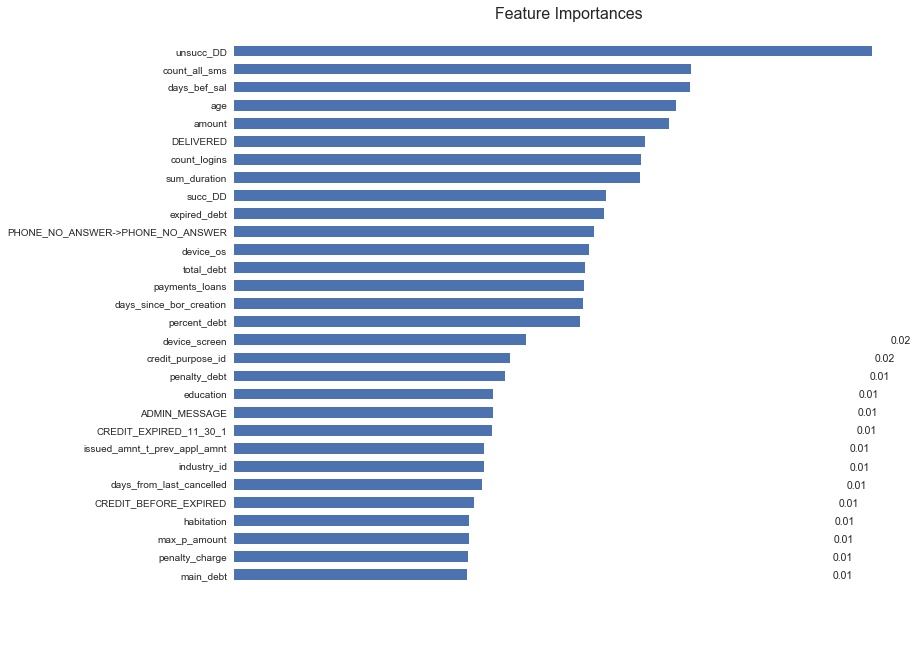

In [267]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.65)

ROC_AUC:   0.6008248981013827
Gini:      0.20164979620276546
F1_score:  0.8759943846513804
Log_loss:  5.994540623564047


Classification_report: 
              precision    recall  f1-score   support

          0       0.44      0.29      0.35      1228
          1       0.84      0.91      0.88      5133

avg / total       0.77      0.79      0.77      6361



Weight,Feature
0.0349 ± 0.0342,unsucc_DD
0.0281 ± 0.0139,days_bef_sal
0.0256 ± 0.0220,count_all_sms
0.0250 ± 0.0136,count_logins
0.0248 ± 0.0113,amount
0.0248 ± 0.0123,age
0.0245 ± 0.0175,sum_duration
0.0229 ± 0.0156,DELIVERED
0.0213 ± 0.0103,expired_debt
0.0211 ± 0.0149,PHONE_NO_ANSWER->PHONE_NO_ANSWER


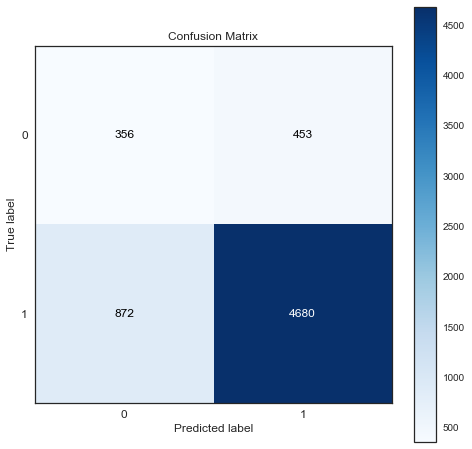

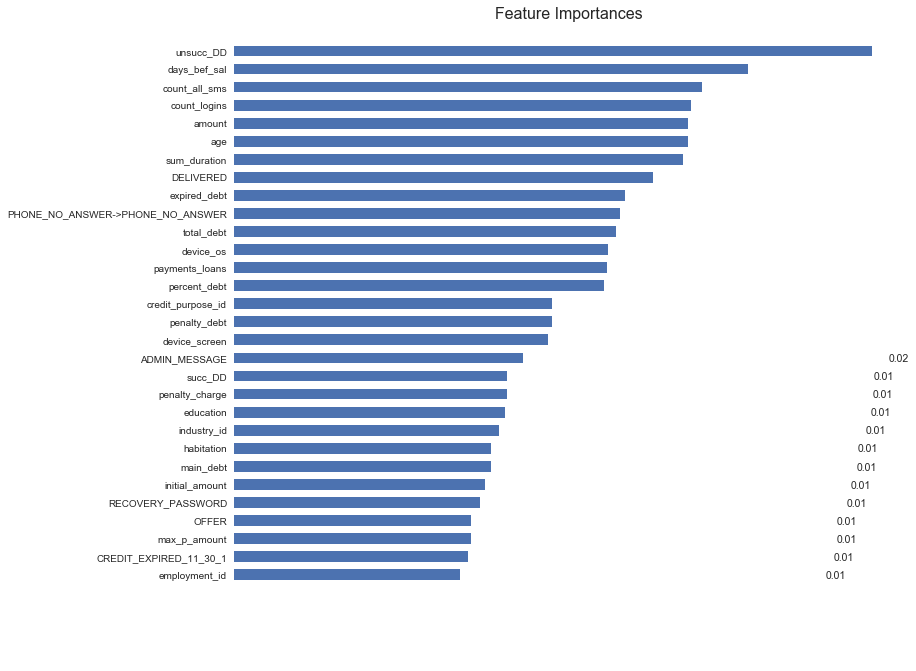

In [163]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.55)

# Model

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [213]:
%%time
clf1 = xgb.XGBClassifier(n_estimators=1000).fit(X_train, y_train)

Wall time: 26.8 s


In [220]:
%%time
clf = GradientBoostingClassifier(random_state=1)

tuned_parameters = {'n_estimators': [60, 80, 100, 120, 300, 500],
                    #'max_depth': [3,5]
                    }
gs = GridSearchCV(clf, tuned_parameters, cv=5, verbose=2).fit(X_train, y_train)
print (gs.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=60 .................................................
[CV] ........................................ n_estimators=60 -   1.6s
[CV] n_estimators=60 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ........................................ n_estimators=60 -   1.6s
[CV] n_estimators=60 .................................................
[CV] ........................................ n_estimators=60 -   1.6s
[CV] n_estimators=60 .................................................
[CV] ........................................ n_estimators=60 -   1.6s
[CV] n_estimators=60 .................................................
[CV] ........................................ n_estimators=60 -   1.6s
[CV] n_estimators=80 .................................................
[CV] ........................................ n_estimators=80 -   2.2s
[CV] n_estimators=80 .................................................
[CV] ........................................ n_estimators=80 -   2.3s
[CV] n_estimators=80 .................................................
[CV] ........................................ n_estimators=80 -   2.3s
[CV] n_estimators=80 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)
Wall time: 2min 28s


In [219]:
%%time
#GRAD_TO_CHECK
clf3 = GradientBoostingClassifier(random_state=1, n_estimators=500).fit(X_train, y_train)

Wall time: 0 ns


In [75]:
%%time
eclf1 = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('grad', clf3)], voting='soft').fit(X_train, y_train)

Wall time: 1min 9s


In [79]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3],
                              weights=[1, 2, 1], voting='soft').fit(X_train, y_train)

In [82]:
%%time
bag = BaggingClassifier(clf2).fit(X_train, y_train)

Wall time: 24.3 s


ROC_AUC:   0.5783567207900371
Gini:      0.15671344158007416
F1_score:  0.6073453290608825
Log_loss:  9.002034184866144


Classification_report: 
              precision    recall  f1-score   support

          0       0.90      0.19      0.31      3827
          1       0.44      0.97      0.61      2546

avg / total       0.72      0.50      0.43      6373



AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

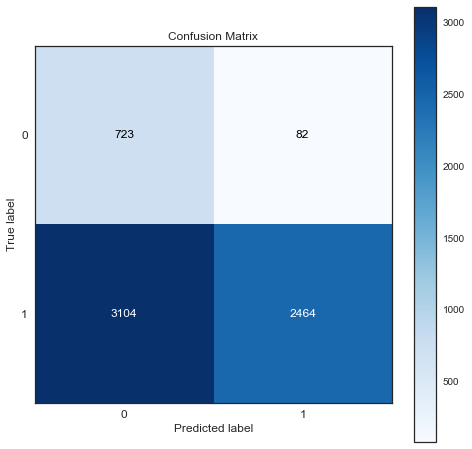

In [229]:
#XGBOOST
IDF.plot_score(gs, X_test, y_test,cut_off=0.65)

# Score and Graphs

ROC_AUC:   0.8720268284590226
Gini:      0.7440536569180451
F1_score:  0.9334303383048381
Log_loss:  3.9727296491607103


Classification_report: 
              precision    recall  f1-score   support

          0       0.44      0.86      0.58       292
          1       0.98      0.89      0.93      2890

avg / total       0.93      0.88      0.90      3182



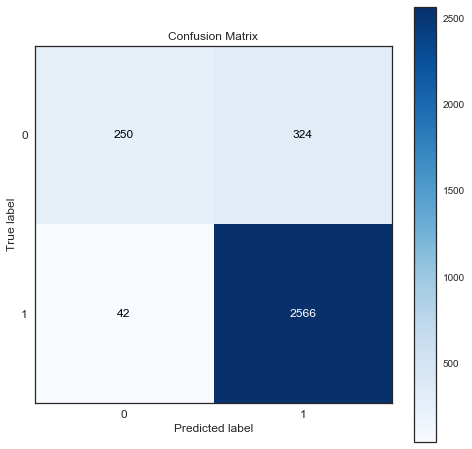

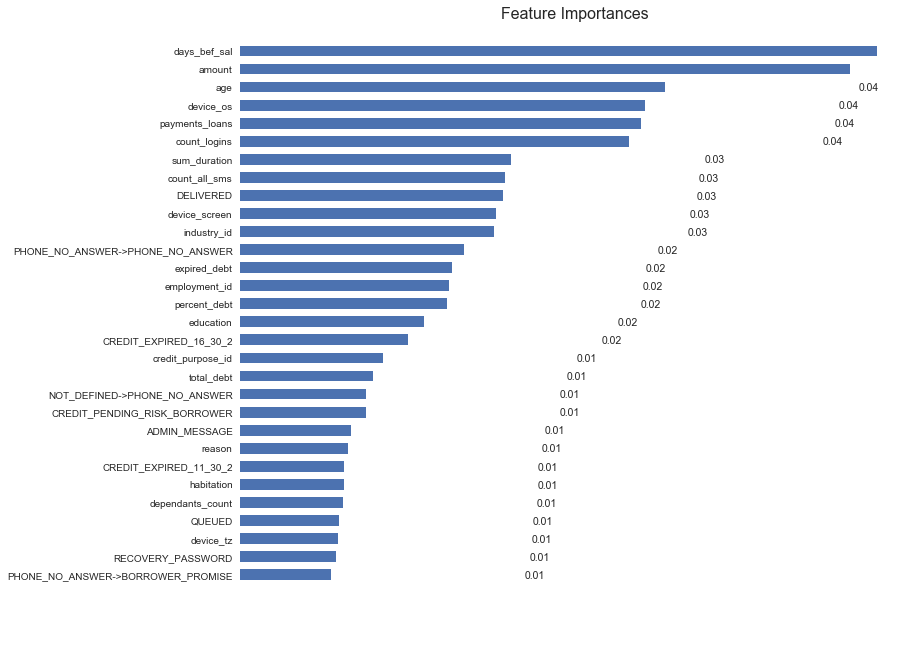

In [49]:
#XGBOOST
IDF.plot_score(clf, X_test, y_test)

ROC_AUC:   0.5986990181209593
Gini:      0.19739803624191854
F1_score:  0.8742032245969253
Log_loss:  4.273244611931958


Classification_report: 
              precision    recall  f1-score   support

          0       0.44      0.29      0.35      1245
          1       0.84      0.91      0.87      5116

avg / total       0.76      0.79      0.77      6361



Weight,Feature
0.0301 ± 0.0210,unsucc_DD
0.0280 ± 0.0110,days_bef_sal
0.0255 ± 0.0105,age
0.0249 ± 0.0183,sum_duration
0.0248 ± 0.0104,amount
0.0244 ± 0.0176,count_all_sms
0.0241 ± 0.0116,count_logins
0.0224 ± 0.0100,expired_debt
0.0222 ± 0.0128,DELIVERED
0.0213 ± 0.0106,total_debt


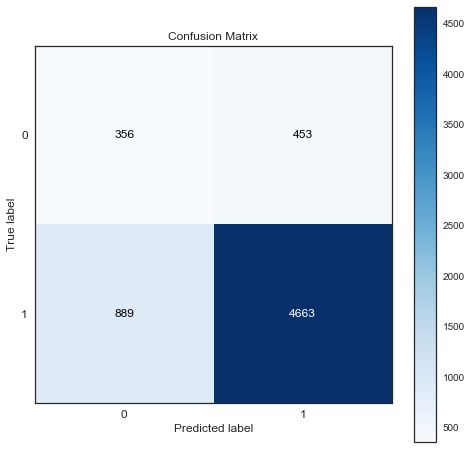

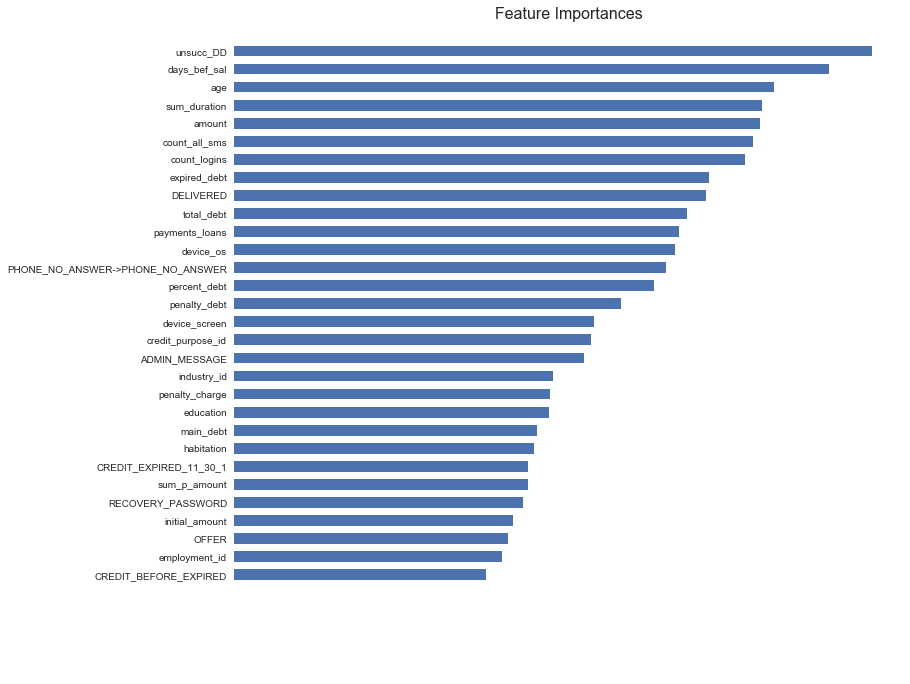

In [136]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.7)

ROC_AUC:   0.5822133240482823
Gini:      0.1644266480965646
F1_score:  0.9247621793023926
Log_loss:  3.9695545582723777


Classification_report: 
              precision    recall  f1-score   support

          0       0.12      0.27      0.17       288
          1       0.96      0.89      0.92      5385

avg / total       0.92      0.86      0.89      5673



Weight,Feature
0.0320 ± 0.0123,days_bef_sal
0.0304 ± 0.0116,amount
0.0286 ± 0.0104,age
0.0284 ± 0.0153,unsucc_DD
0.0271 ± 0.0112,count_logins
0.0262 ± 0.0121,count_all_sms
0.0255 ± 0.0108,payments_loans
0.0252 ± 0.0106,device_os
0.0243 ± 0.0106,DELIVERED
0.0230 ± 0.0098,expired_debt


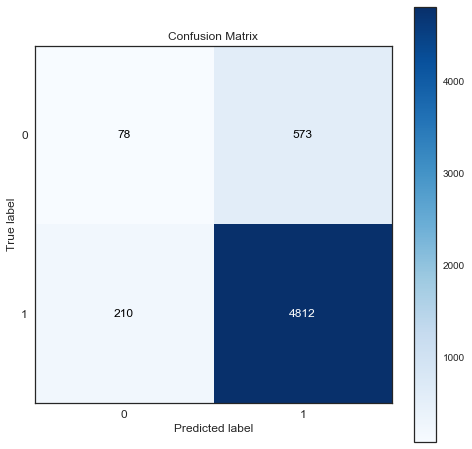

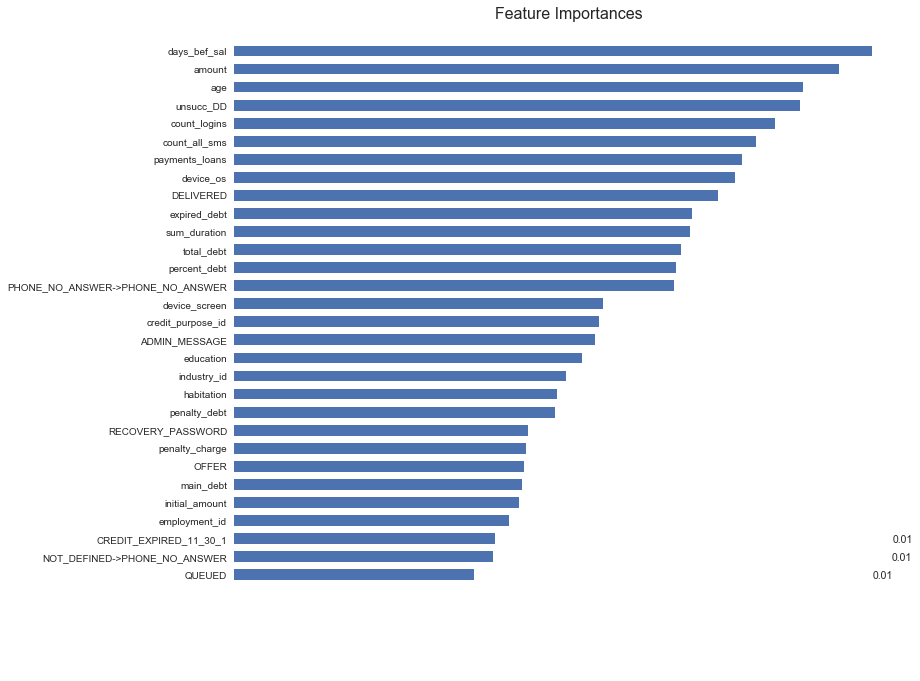

In [58]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.75)

ROC_AUC:   0.8165854243247562
Gini:      0.6331708486495125
F1_score:  0.9358963502413414
Log_loss:  4.110340279905765


Classification_report: 
              precision    recall  f1-score   support

          0       0.10      0.75      0.17       104
          1       1.00      0.88      0.94      6257

avg / total       0.98      0.88      0.92      6361



Weight,Feature
0.0287 ± 0.0101,days_bef_sal
0.0263 ± 0.0140,unsucc_DD
0.0257 ± 0.0089,age
0.0254 ± 0.0143,count_all_sms
0.0253 ± 0.0099,amount
0.0248 ± 0.0096,count_logins
0.0235 ± 0.0093,expired_debt
0.0229 ± 0.0097,total_debt
0.0226 ± 0.0134,sum_duration
0.0222 ± 0.0103,DELIVERED


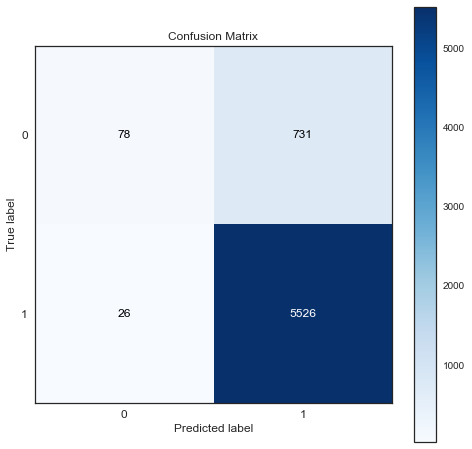

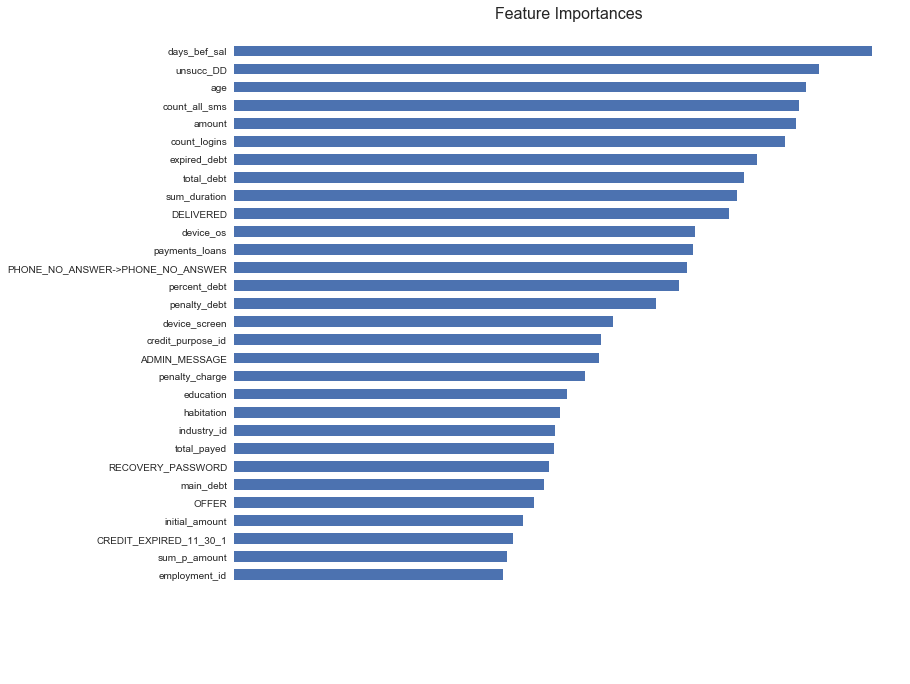

In [34]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.5)

ROC_AUC:   0.9325483620637806
Gini:      0.8650967241275611
F1_score:  0.9368591473286562
Log_loss:  3.8099037438728383


Classification_report: 
              precision    recall  f1-score   support

          0       0.40      0.98      0.56       231
          1       1.00      0.88      0.94      2951

avg / total       0.95      0.89      0.91      3182



Weight,Feature
0.1030 ± 0.2124,CREDIT_EXPIRED_16_30_2
0.0664 ± 0.1869,CREDIT_EXPIRED_16_30_1
0.0361 ± 0.1320,CREDIT_EXPIRED_6_15_3
0.0333 ± 0.0167,days_bef_sal
0.0270 ± 0.0480,CREDIT_EXPIRED_11_30_2
0.0269 ± 0.1058,PHONE_NO_ANSWER->COLLECTORS_MESSAGE
0.0238 ± 0.0256,sum_duration
0.0238 ± 0.0367,count_all_sms
0.0219 ± 0.0106,age
0.0217 ± 0.0108,amount


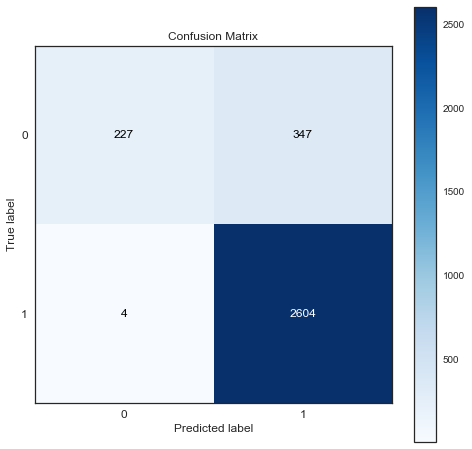

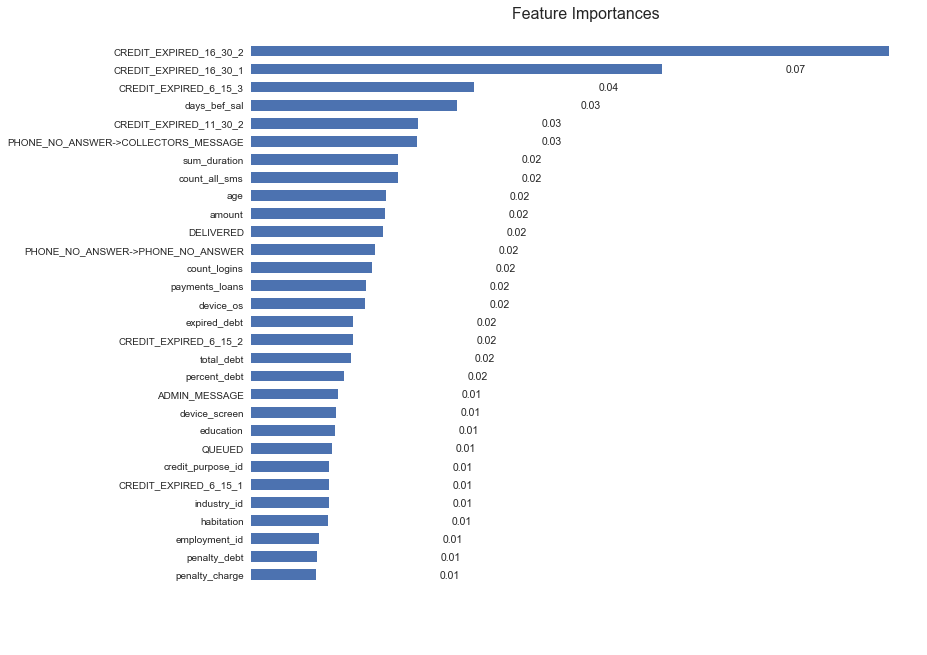

In [101]:
#RF
IDF.plot_score(clf2, X_test, y_test, cut_off=0.5)

ROC_AUC:   0.896502474924447
Gini:      0.793004949848894
F1_score:  0.9361856417693981
Log_loss:  3.820763695959066


Classification_report: 
              precision    recall  f1-score   support

          0       0.43      0.91      0.58       274
          1       0.99      0.89      0.94      2908

avg / total       0.94      0.89      0.91      3182



Weight,Feature
0.3555 ± 0.7130,CREDIT_EXPIRED_16_30_2
0.0570 ± 0.1781,days_bef_sal
0.0388 ± 0.1788,device_os
0.0297 ± 0.1170,DELIVERED
0.0236 ± 0.1324,employment_id
0.0194 ± 0.1379,NOT_DEFINED->REPLY_CONSULTATION
0.0192 ± 0.1041,CREDIT_PENDING_RISK_BORROWER
0.0184 ± 0.1107,PHONE_NO_ANSWER->BORROWER_PROMISE
0.0183 ± 0.0778,CREDIT_EXPIRED_11_30_2
0.0182 ± 0.1281,sum_duration


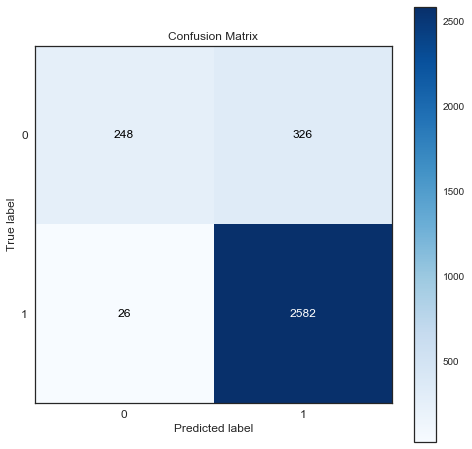

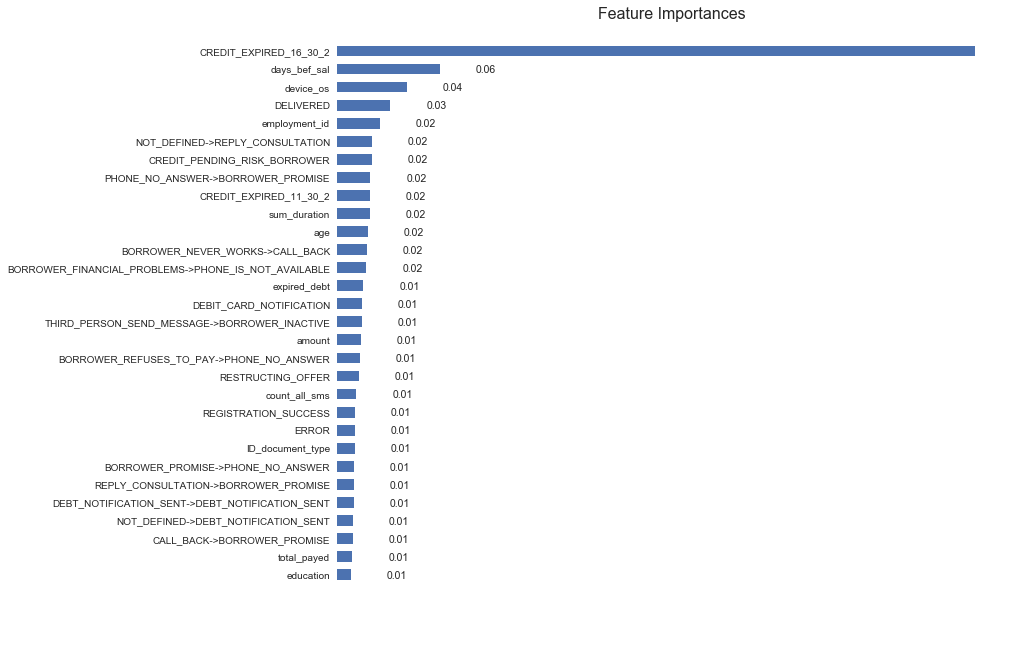

In [58]:
#Grad_gs
IDF.plot_score(gs.best_estimator_, X_test, y_test)

ROC_AUC:   0.9325483620637806
Gini:      0.8650967241275611
F1_score:  0.9368591473286562
Log_loss:  3.8099037438728383


Classification_report: 
              precision    recall  f1-score   support

          0       0.40      0.98      0.56       231
          1       1.00      0.88      0.94      2951

avg / total       0.95      0.89      0.91      3182



Weight,Feature
0.1030 ± 0.2124,CREDIT_EXPIRED_16_30_2
0.0664 ± 0.1869,CREDIT_EXPIRED_16_30_1
0.0361 ± 0.1320,CREDIT_EXPIRED_6_15_3
0.0333 ± 0.0167,days_bef_sal
0.0270 ± 0.0480,CREDIT_EXPIRED_11_30_2
0.0269 ± 0.1058,PHONE_NO_ANSWER->COLLECTORS_MESSAGE
0.0238 ± 0.0256,sum_duration
0.0238 ± 0.0367,count_all_sms
0.0219 ± 0.0106,age
0.0217 ± 0.0108,amount


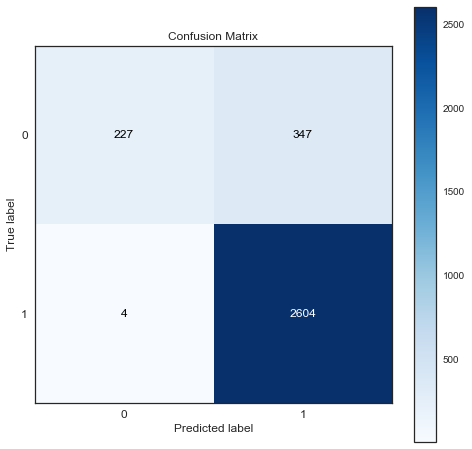

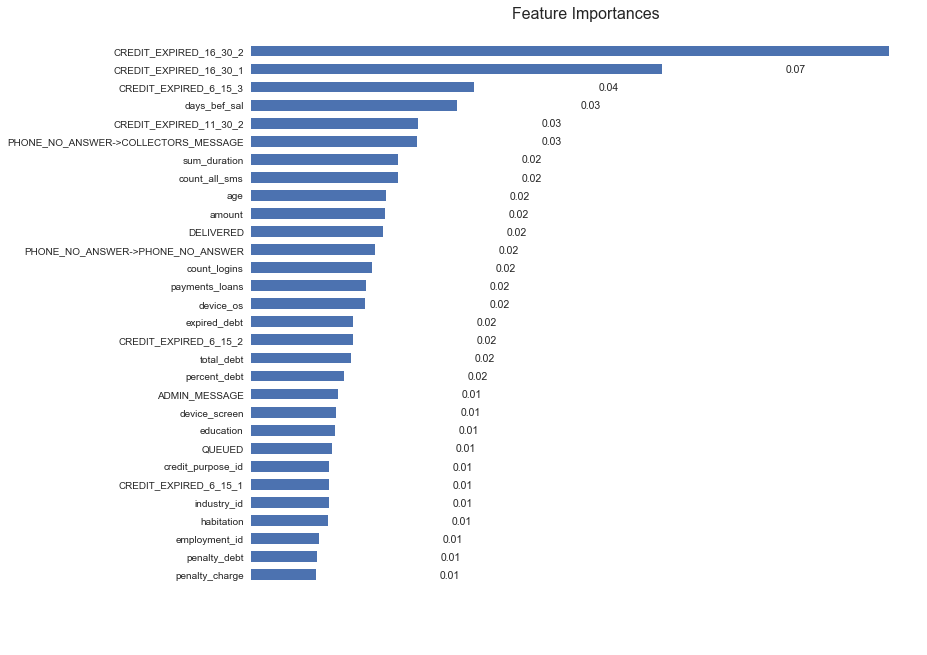

In [66]:
#Grad_clf
IDF.plot_score(clf2, X_test, y_test)

ROC_AUC:   0.8945057179288948
Gini:      0.7890114358577895
F1_score:  0.9358230601885424
Log_loss:  3.8424727947608415


Classification_report: 
              precision    recall  f1-score   support

          0       0.43      0.90      0.58       274
          1       0.99      0.89      0.94      2908

avg / total       0.94      0.89      0.91      3182



AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

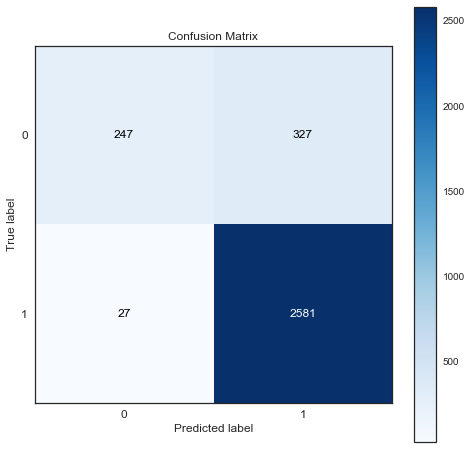

In [76]:
#Voting
IDF.plot_score(eclf1, X_test, y_test)

ROC_AUC:   0.9076409225912311
Gini:      0.8152818451824622
F1_score:  0.9370249728555918
Log_loss:  3.777344241917062


Classification_report: 
              precision    recall  f1-score   support

          0       0.43      0.93      0.58       264
          1       0.99      0.89      0.94      2918

avg / total       0.95      0.89      0.91      3182



AttributeError: 'EnsembleVoteClassifier' object has no attribute 'feature_importances_'

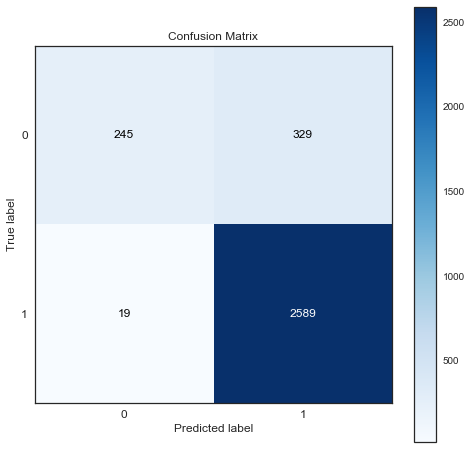

In [80]:
#Voting_MLXETEND
IDF.plot_score(eclf, X_test, y_test)

ROC_AUC:   0.9412859560067681
Gini:      0.8825719120135362
F1_score:  0.9376235843969082
Log_loss:  3.766485043693906


Classification_report: 
              precision    recall  f1-score   support

          0       0.40      1.00      0.57       227
          1       1.00      0.88      0.94      2955

avg / total       0.96      0.89      0.91      3182



AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

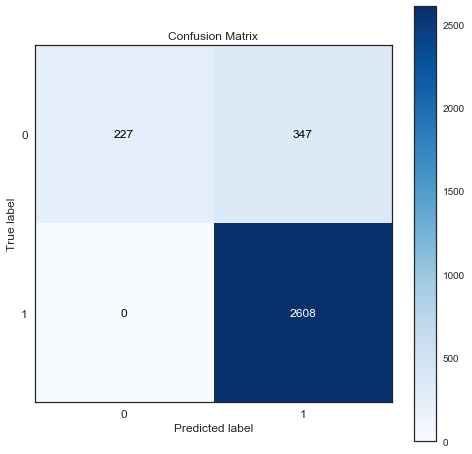

In [84]:
#BAGGING RF
IDF.plot_score(bag, X_test, y_test)

In [89]:
joblib.dump(clf3, 'ES_col_30.pkl');

In [771]:
qq = X.copy()
qq['preds_proba'] = clf3.predict_proba(X)[:,1]
qq['preds'] = clf3.predict(X)
qq['credit_id'] = ids
qq['real'] = y
qq = qq[['credit_id', 'preds', 'preds_proba', 'real']]

In [772]:
r = pd.concat([qq, X], axis=1)

# Only for credits between dates

In [40]:
min_date = '2017-03-19'
max_date = '2017-03-19' 

In [41]:
%%time
df = pd.read_sql('''
SELECT
    1 AS is_bad,
    1                   AS is_very_bad,
    datediff(w.next_income_date, c.date_requested) as days_bef_sal,
    cc1.*,
    p_d.*,
    w.*,
    i.*,
    b.is_filled_idv,
    b.is_reset_bank_account,
    b.has_online_banking
FROM moneyman_es.credit_calculations cc1
    LEFT JOIN moneyman_es.credit c
        ON cc1.credit_id = c.id
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.personal_data p_d
        ON b.personal_data_id = p_d.id
    LEFT JOIN moneyman_es.iovation i
        ON i.credit_id = c.id
WHERE cc1.calculation_date>='%s' and cc1.status='EXPIRED' and cc1.calculation_date<='%s' and cc1.status_days_count = 30 AND credit_number = 1 AND c.date_requested>'2017-01-01'
order by cc1.credit_id
''' % (str(min_date), str(max_date)), con=con())
df['age'] = 2018 - df['birthday'].apply(lambda x: x.year)
df1 = df.copy()
#df = df.sample(frac=1).reset_index(drop=True)

Wall time: 391 ms


In [42]:
%%time
# SMS-Notifitcations
sms = pd.read_sql('''
SELECT
    cc.credit_id,
    n.*
FROM moneyman_es.notification_sms n LEFT JOIN moneyman_es.borrower b
        ON n.borrower_id = b.id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND n.date_sent < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
sms1 = sms.copy()

Wall time: 869 ms


In [43]:
%%time
# Payments
payments = pd.read_sql('''
SELECT cp.*
FROM moneyman_es.credit_payment cp LEFT JOIN moneyman_es.credit_calculations cc
        ON cp.credit_id = cc.credit_id
    LEFT JOIN moneyman_es.credit c
        ON cc.credit_id = c.id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED' and cc.calculation_date<='%s' and cc.expired_days_count = 30 AND cp.payment_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
payments1 = payments.copy()

Wall time: 312 ms


In [44]:
%%time
# Logins on site
logins = pd.read_sql('''
SELECT
    cc.credit_id,
    ul.*
FROM moneyman_es.user_login_history ul LEFT JOIN moneyman_es.borrower b
        ON ul.user_id = b.user_account_id
    LEFT JOIN moneyman_es.credit c
        ON b.id = c.borrower_id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND ul.login_date < cc.calculation_date AND credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
logins1 = logins.copy()

Wall time: 302 ms


In [45]:
%%time
# Collectors Calls
colcalls = pd.read_sql('''
SELECT
    coc.credit_id,
    cac.*
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE  cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND cac.call_date < cc.calculation_date AND c.credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
colcalls1 = colcalls.copy()

Wall time: 387 ms


In [71]:
colcs_columns

NameError: name 'colcs_columns' is not defined

In [46]:
sms_columns = [
    'credit_id', 'ADMIN_MESSAGE', 'AWAITING_PHONE_CONFIRMATION',
    'CONFIRMATION_CODE', 'CREDIT_BEFORE_EXPIRED',
    'CREDIT_BEFORE_EXPIRED_PROMISE', 'CREDIT_COMPLETED', 'CREDIT_EXPIRED',
    'CREDIT_EXPIRED_11_30_1', 'CREDIT_EXPIRED_11_30_2',
    'CREDIT_EXPIRED_11_30_3', 'CREDIT_EXPIRED_11_30_4',
    'CREDIT_EXPIRED_1_10_1', 'CREDIT_EXPIRED_1_10_2', 'CREDIT_EXPIRED_1_10_3',
    'CREDIT_EXPIRED_1_10_4', 'CREDIT_EXPIRED_31_45_1',
    'CREDIT_EXPIRED_31_45_2', 'CREDIT_EXPIRED_31_45_4',
    'CREDIT_EXPIRED_46_60_1', 'CREDIT_EXPIRED_46_60_2',
    'CREDIT_EXPIRED_PROMISE', 'CREDIT_PENDING_RISK_BORROWER',
    'DEBIT_CARD_NOTIFICATION', 'OFFER', 'PAYMENT_COMPLETED',
    'PAYMENT_RECEIVED', 'PRE_APPROVAL_LOANS_NOTIFICATIONS_1',
    'RECOVERY_PASSWORD', 'REGISTRATION_SUCCESS', 'RESTRUCTING_FIRST_PAYMENT',
    'RESTRUCTING_OFFER', 'RESTRUCTING_TODAY_PAYMENT',
    'RESTRUCTING_TOMORROW_PAYMENT', 'ROLLOVER_CREDIT_TODAY_ENDS',
    'ROLLOVER_CREDIT_TOMORROW_ENDS', 'SCORING_LIMIT_CREDIT_AMOUNT',
    'SENT_MONEY', 'count_all_sms', 'DELIVERED', 'ERROR', 'NOT_DELIVERED',
    'PREPARED_FOR_SENDING', 'QUEUED', 'REJECTD'
]

colcs_columns = [
    'credit_id', 'BORROWER_DID_NOT_TAKE_CREDIT->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_DID_NOT_TAKE_CREDIT->BORROWER_REFUSES_TO_PAY',
    'BORROWER_DID_NOT_TAKE_CREDIT->NO_FUNDS_ON_ACCOUNT',
    'BORROWER_DID_NOT_TAKE_CREDIT->PHONE_NO_ANSWER',
    'BORROWER_DID_NOT_TAKE_CREDIT->REFUSE_TO_COMMUNICATE',
    'BORROWER_DID_NOT_TAKE_CREDIT->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_PROMISE',
    'BORROWER_FINANCIAL_PROBLEMS->BORROWER_REFUSES_TO_PAY',
    'BORROWER_FINANCIAL_PROBLEMS->CALL_BACK',
    'BORROWER_FINANCIAL_PROBLEMS->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_FINANCIAL_PROBLEMS->MONEY_SENT',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_NOT_USED',
    'BORROWER_FINANCIAL_PROBLEMS->PHONE_NO_ANSWER',
    'BORROWER_FINANCIAL_PROBLEMS->REFUSE_TO_COMMUNICATE',
    'BORROWER_FINANCIAL_PROBLEMS->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_INACTIVE->BORROWER_PROMISE', 'BORROWER_INACTIVE->CALL_BACK',
    'BORROWER_INACTIVE->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_INACTIVE->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_INACTIVE->PHONE_NO_ANSWER',
    'BORROWER_INACTIVE->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_NEVER_WORKS->BORROWER_NEVER_WORKS',
    'BORROWER_NEVER_WORKS->BORROWER_NO_LONGER_WORKS',
    'BORROWER_NEVER_WORKS->CALL_BACK', 'BORROWER_NEVER_WORKS->PHONE_NO_ANSWER',
    'BORROWER_NEVER_WORKS->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_NO_LONGER_WORKS->BORROWER_NO_LONGER_WORKS',
    'BORROWER_NO_LONGER_WORKS->BORROWER_REFUSES_TO_PAY',
    'BORROWER_NO_LONGER_WORKS->PHONE_NO_ANSWER',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_NEGATIVE',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_NO_LONGER_WORKS->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_PROMISE->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_PROMISE->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_PROMISE->BORROWER_INACTIVE',
    'BORROWER_PROMISE->BORROWER_PROMISE',
    'BORROWER_PROMISE->BORROWER_REFUSES_TO_PAY', 'BORROWER_PROMISE->CALL_BACK',
    'BORROWER_PROMISE->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_PROMISE->DEBT_NOTIFICATION_SENT', 'BORROWER_PROMISE->MONEY_SENT',
    'BORROWER_PROMISE->NO_FUNDS_ON_ACCOUNT',
    'BORROWER_PROMISE->PAYMENT_CONFIRMATION',
    'BORROWER_PROMISE->PHONE_BELONG_ANOTHER_PERSON',
    'BORROWER_PROMISE->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_PROMISE->PHONE_NOT_USED', 'BORROWER_PROMISE->PHONE_NO_ANSWER',
    'BORROWER_PROMISE->REFUSE_TO_COMMUNICATE',
    'BORROWER_PROMISE->REPLY_CONSULTATION',
    'BORROWER_PROMISE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'BORROWER_PROMISE->THIRD_PERSON_NEGATIVE',
    'BORROWER_PROMISE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_PROMISE->THIRD_PERSON_SEND_MESSAGE',
    'BORROWER_REFUSES_TO_PAY->BORROWER_DID_NOT_TAKE_CREDIT',
    'BORROWER_REFUSES_TO_PAY->BORROWER_FINANCIAL_PROBLEMS',
    'BORROWER_REFUSES_TO_PAY->BORROWER_NEVER_WORKS',
    'BORROWER_REFUSES_TO_PAY->BORROWER_PROMISE',
    'BORROWER_REFUSES_TO_PAY->BORROWER_REFUSES_TO_PAY',
    'BORROWER_REFUSES_TO_PAY->CALL_BACK',
    'BORROWER_REFUSES_TO_PAY->CLIENT_MADE_PAYMENT_LOAN',
    'BORROWER_REFUSES_TO_PAY->DEBT_NOTIFICATION_SENT',
    'BORROWER_REFUSES_TO_PAY->MONEY_SENT',
    'BORROWER_REFUSES_TO_PAY->PHONE_BELONG_ANOTHER_PERSON',
    'BORROWER_REFUSES_TO_PAY->PHONE_IS_NOT_AVAILABLE',
    'BORROWER_REFUSES_TO_PAY->PHONE_NOT_USED',
    'BORROWER_REFUSES_TO_PAY->PHONE_NO_ANSWER',
    'BORROWER_REFUSES_TO_PAY->REFUSE_TO_COMMUNICATE',
    'BORROWER_REFUSES_TO_PAY->REPLY_CONSULTATION',
    'BORROWER_REFUSES_TO_PAY->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'BORROWER_REFUSES_TO_PAY->THIRD_PERSON_SEND_MESSAGE',
    'CALL_BACK->BORROWER_DID_NOT_TAKE_CREDIT',
    'CALL_BACK->BORROWER_FINANCIAL_PROBLEMS', 'CALL_BACK->BORROWER_INACTIVE',
    'CALL_BACK->BORROWER_NEVER_WORKS', 'CALL_BACK->BORROWER_PROMISE',
    'CALL_BACK->BORROWER_REFUSES_TO_PAY', 'CALL_BACK->CALL_BACK',
    'CALL_BACK->CLIENT_MADE_PAYMENT_LOAN', 'CALL_BACK->MONEY_SENT',
    'CALL_BACK->PHONE_BELONG_ANOTHER_PERSON',
    'CALL_BACK->PHONE_IS_NOT_AVAILABLE', 'CALL_BACK->PHONE_NOT_USED',
    'CALL_BACK->PHONE_NO_ANSWER', 'CALL_BACK->REFUSE_TO_COMMUNICATE',
    'CALL_BACK->THIRD_PERSON_NEGATIVE',
    'CALL_BACK->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'CALL_BACK->THIRD_PERSON_SEND_MESSAGE',
    'CLAIM_OF_INCORRECT_EMAIL->CLAIM_OF_INCORRECT_EMAIL',
    'CLAIM_OF_INCORRECT_EMAIL->DEBT_NOTIFICATION_SENT',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_FINANCIAL_PROBLEMS',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_PROMISE',
    'CLIENT_MADE_PAYMENT_LOAN->BORROWER_REFUSES_TO_PAY',
    'CLIENT_MADE_PAYMENT_LOAN->CALL_BACK',
    'CLIENT_MADE_PAYMENT_LOAN->CLIENT_MADE_PAYMENT_LOAN',
    'CLIENT_MADE_PAYMENT_LOAN->MONEY_SENT',
    'CLIENT_MADE_PAYMENT_LOAN->PHONE_IS_NOT_AVAILABLE',
    'CLIENT_MADE_PAYMENT_LOAN->PHONE_NO_ANSWER',
    'CLIENT_MADE_PAYMENT_LOAN->REFUSE_TO_COMMUNICATE',
    'CLIENT_MADE_PAYMENT_LOAN->THIRD_PERSON_SEND_MESSAGE',
    'DEBT_NOTIFICATION_SENT->BORROWER_PROMISE',
    'DEBT_NOTIFICATION_SENT->BORROWER_REFUSES_TO_PAY',
    'DEBT_NOTIFICATION_SENT->CLAIM_OF_INCORRECT_EMAIL',
    'DEBT_NOTIFICATION_SENT->DEBT_NOTIFICATION_SENT',
    'DEBT_NOTIFICATION_SENT->PAYMENT_CONFIRMATION',
    'DEBT_NOTIFICATION_SENT->REPLY_CONSULTATION',
    'MONEY_SENT->BORROWER_FINANCIAL_PROBLEMS', 'MONEY_SENT->BORROWER_PROMISE',
    'MONEY_SENT->BORROWER_REFUSES_TO_PAY', 'MONEY_SENT->CALL_BACK',
    'MONEY_SENT->CLIENT_MADE_PAYMENT_LOAN', 'MONEY_SENT->MONEY_SENT',
    'MONEY_SENT->NO_FUNDS_ON_ACCOUNT', 'MONEY_SENT->PHONE_NO_ANSWER',
    'MONEY_SENT->REFUSE_TO_COMMUNICATE',
    'MONEY_SENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'NOT_DEFINED->BORROWER_DID_NOT_TAKE_CREDIT',
    'NOT_DEFINED->BORROWER_FINANCIAL_PROBLEMS',
    'NOT_DEFINED->BORROWER_INACTIVE', 'NOT_DEFINED->BORROWER_NEVER_WORKS',
    'NOT_DEFINED->BORROWER_NO_LONGER_WORKS', 'NOT_DEFINED->BORROWER_PROMISE',
    'NOT_DEFINED->BORROWER_REFUSES_TO_PAY', 'NOT_DEFINED->CALL_BACK',
    'NOT_DEFINED->CLAIM_OF_INCORRECT_EMAIL',
    'NOT_DEFINED->CLIENT_MADE_PAYMENT_LOAN',
    'NOT_DEFINED->DEBT_NOTIFICATION_SENT', 'NOT_DEFINED->MONEY_SENT',
    'NOT_DEFINED->NO_FUNDS_ON_ACCOUNT', 'NOT_DEFINED->PAYMENT_CONFIRMATION',
    'NOT_DEFINED->PHONE_BELONG_ANOTHER_PERSON',
    'NOT_DEFINED->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'NOT_DEFINED->PHONE_IS_NOT_AVAILABLE', 'NOT_DEFINED->PHONE_NOT_USED',
    'NOT_DEFINED->PHONE_NO_ANSWER', 'NOT_DEFINED->REFUSE_TO_COMMUNICATE',
    'NOT_DEFINED->REPLY_CONSULTATION', 'NOT_DEFINED->RESTRUCTURIZATION_AGREED',
    'NOT_DEFINED->THIRD_PERSON_DONT_KNOW_CLIENT',
    'NOT_DEFINED->THIRD_PERSON_NEGATIVE',
    'NOT_DEFINED->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'NOT_DEFINED->THIRD_PERSON_SEND_MESSAGE',
    'NO_FUNDS_ON_ACCOUNT->BORROWER_REFUSES_TO_PAY',
    'NO_FUNDS_ON_ACCOUNT->CLIENT_MADE_PAYMENT_LOAN',
    'NO_FUNDS_ON_ACCOUNT->NO_FUNDS_ON_ACCOUNT',
    'NO_FUNDS_ON_ACCOUNT->PHONE_NO_ANSWER',
    'NO_FUNDS_ON_ACCOUNT->REFUSE_TO_COMMUNICATE',
    'NO_FUNDS_ON_ACCOUNT->THIRD_PERSON_SEND_MESSAGE',
    'PAYMENT_CONFIRMATION->BORROWER_PROMISE',
    'PAYMENT_CONFIRMATION->BORROWER_REFUSES_TO_PAY',
    'PAYMENT_CONFIRMATION->DEBT_NOTIFICATION_SENT',
    'PAYMENT_CONFIRMATION->PAYMENT_CONFIRMATION',
    'PAYMENT_CONFIRMATION->REPLY_CONSULTATION',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_DID_NOT_TAKE_CREDIT',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_NEVER_WORKS',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_NO_LONGER_WORKS',
    'PHONE_BELONG_ANOTHER_PERSON->BORROWER_REFUSES_TO_PAY',
    'PHONE_BELONG_ANOTHER_PERSON->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_BELONG_ANOTHER_PERSON->PHONE_NO_ANSWER',
    'PHONE_BELONG_ANOTHER_PERSON->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_BELONG_ANOTHER_PERSON->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->PHONE_NO_ANSWER',
    'PHONE_BELONG_ORG_DONT_KNOW_CLIENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_INACTIVE',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_NEVER_WORKS',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_PROMISE',
    'PHONE_IS_NOT_AVAILABLE->BORROWER_REFUSES_TO_PAY',
    'PHONE_IS_NOT_AVAILABLE->CALL_BACK',
    'PHONE_IS_NOT_AVAILABLE->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_IS_NOT_AVAILABLE->PHONE_IS_NOT_AVAILABLE',
    'PHONE_IS_NOT_AVAILABLE->PHONE_NOT_USED',
    'PHONE_IS_NOT_AVAILABLE->PHONE_NO_ANSWER',
    'PHONE_IS_NOT_AVAILABLE->REFUSE_TO_COMMUNICATE',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_NEGATIVE',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_IS_NOT_AVAILABLE->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_NOT_USED->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_NOT_USED->BORROWER_NO_LONGER_WORKS',
    'PHONE_NOT_USED->BORROWER_PROMISE',
    'PHONE_NOT_USED->BORROWER_REFUSES_TO_PAY', 'PHONE_NOT_USED->CALL_BACK',
    'PHONE_NOT_USED->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_NOT_USED->PHONE_IS_NOT_AVAILABLE', 'PHONE_NOT_USED->PHONE_NOT_USED',
    'PHONE_NOT_USED->PHONE_NO_ANSWER', 'PHONE_NOT_USED->REFUSE_TO_COMMUNICATE',
    'PHONE_NOT_USED->THIRD_PERSON_SEND_MESSAGE',
    'PHONE_NO_ANSWER->BORROWER_DID_NOT_TAKE_CREDIT',
    'PHONE_NO_ANSWER->BORROWER_FINANCIAL_PROBLEMS',
    'PHONE_NO_ANSWER->BORROWER_INACTIVE',
    'PHONE_NO_ANSWER->BORROWER_NEVER_WORKS',
    'PHONE_NO_ANSWER->BORROWER_NO_LONGER_WORKS',
    'PHONE_NO_ANSWER->BORROWER_PROMISE',
    'PHONE_NO_ANSWER->BORROWER_REFUSES_TO_PAY', 'PHONE_NO_ANSWER->CALL_BACK',
    'PHONE_NO_ANSWER->CLIENT_MADE_PAYMENT_LOAN', 'PHONE_NO_ANSWER->MONEY_SENT',
    'PHONE_NO_ANSWER->NO_FUNDS_ON_ACCOUNT',
    'PHONE_NO_ANSWER->PHONE_BELONG_ANOTHER_PERSON',
    'PHONE_NO_ANSWER->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'PHONE_NO_ANSWER->PHONE_IS_NOT_AVAILABLE',
    'PHONE_NO_ANSWER->PHONE_NOT_USED', 'PHONE_NO_ANSWER->PHONE_NO_ANSWER',
    'PHONE_NO_ANSWER->REFUSE_TO_COMMUNICATE',
    'PHONE_NO_ANSWER->THIRD_PERSON_DONT_KNOW_CLIENT',
    'PHONE_NO_ANSWER->THIRD_PERSON_NEGATIVE',
    'PHONE_NO_ANSWER->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'PHONE_NO_ANSWER->THIRD_PERSON_SEND_MESSAGE',
    'REFUSE_TO_COMMUNICATE->BORROWER_FINANCIAL_PROBLEMS',
    'REFUSE_TO_COMMUNICATE->BORROWER_NEVER_WORKS',
    'REFUSE_TO_COMMUNICATE->BORROWER_PROMISE',
    'REFUSE_TO_COMMUNICATE->BORROWER_REFUSES_TO_PAY',
    'REFUSE_TO_COMMUNICATE->CALL_BACK', 'REFUSE_TO_COMMUNICATE->MONEY_SENT',
    'REFUSE_TO_COMMUNICATE->PHONE_BELONG_ANOTHER_PERSON',
    'REFUSE_TO_COMMUNICATE->PHONE_IS_NOT_AVAILABLE',
    'REFUSE_TO_COMMUNICATE->PHONE_NOT_USED',
    'REFUSE_TO_COMMUNICATE->PHONE_NO_ANSWER',
    'REFUSE_TO_COMMUNICATE->REFUSE_TO_COMMUNICATE',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_NEGATIVE',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'REFUSE_TO_COMMUNICATE->THIRD_PERSON_SEND_MESSAGE',
    'REPLY_CONSULTATION->BORROWER_PROMISE',
    'REPLY_CONSULTATION->BORROWER_REFUSES_TO_PAY',
    'REPLY_CONSULTATION->DEBT_NOTIFICATION_SENT',
    'REPLY_CONSULTATION->PAYMENT_CONFIRMATION',
    'REPLY_CONSULTATION->REPLY_CONSULTATION',
    'RESTRUCTURIZATION_AGREED->DEBT_NOTIFICATION_SENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->PHONE_NO_ANSWER',
    'THIRD_PERSON_DONT_KNOW_CLIENT->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_DONT_KNOW_CLIENT->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_NEGATIVE->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_NEGATIVE->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_NEGATIVE->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_NEGATIVE->PHONE_NO_ANSWER',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_NEGATIVE->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_DID_NOT_TAKE_CREDIT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_PROMISE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_IS_NOT_AVAILABLE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->PHONE_NO_ANSWER',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_NEGATIVE_ABOUT_CLIENT->THIRD_PERSON_SEND_MESSAGE',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_DID_NOT_TAKE_CREDIT',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_FINANCIAL_PROBLEMS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_NEVER_WORKS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_NO_LONGER_WORKS',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_PROMISE',
    'THIRD_PERSON_SEND_MESSAGE->BORROWER_REFUSES_TO_PAY',
    'THIRD_PERSON_SEND_MESSAGE->CALL_BACK',
    'THIRD_PERSON_SEND_MESSAGE->CLIENT_MADE_PAYMENT_LOAN',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_BELONG_ANOTHER_PERSON',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_BELONG_ORG_DONT_KNOW_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_IS_NOT_AVAILABLE',
    'THIRD_PERSON_SEND_MESSAGE->PHONE_NO_ANSWER',
    'THIRD_PERSON_SEND_MESSAGE->REFUSE_TO_COMMUNICATE',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_DONT_KNOW_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_NEGATIVE',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_NEGATIVE_ABOUT_CLIENT',
    'THIRD_PERSON_SEND_MESSAGE->THIRD_PERSON_SEND_MESSAGE', 'min_duration',
    'max_duration', 'sum_duration'
]
sms_df = pd.DataFrame(columns=sms_columns)
colcs_df = pd.DataFrame(columns=colcs_columns)

In [47]:
#sms_df = pd.DataFrame(columns=sms_columns)
#df_sp = pd.concat([q_pos, df_sp], axis=0, join='outer')

In [48]:
# SMS Preprocessing
sms = sms[['credit_id', 'date_sent', 'sms_provider_status', 'sms_status', 'sms_message_type', 'sms_sender_type']]
sms_pivot1 = sms.pivot_table(index = ['credit_id'], columns = 'sms_message_type', aggfunc='size').reset_index().fillna(0)
sms_pivot1['count_all_sms'] = sms.groupby('credit_id').agg({'sms_status': 'count'}).reset_index().sms_status
sms_pivot2 = sms.pivot_table(index=['credit_id'], columns='sms_status',
                             aggfunc='size').reset_index().fillna(0).drop('credit_id', axis=1)
sms = pd.concat([sms_pivot1, sms_pivot2], axis=1)
sms = pd.concat([sms, sms_df], axis=0, join='outer')

# logins
logs2 = logins.groupby('credit_id').agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_logins'})
logs2['max_log_date'] = logins.groupby('credit_id').agg(
    {'login_date': 'max'}).reset_index().drop('credit_id', axis=1)
logins = logs2.copy()

# payments
payments = payments[['credit_id', 'amount', 'days_between_payments', 'payment_source',
                     'percent_to_pay', 'goal', 'goal_amount', 'collector_id', 'is_recurrent']]
p1 = payments.groupby('credit_id').agg({'is_recurrent': 'sum'}).reset_index().fillna(0)
p1['count_payments'] = payments.groupby('credit_id').agg({'goal': 'count'}).reset_index().fillna(0).rename(columns={'goal': 'count_payments'}).drop(
    'credit_id', axis=1)
p1['sum_p_amount'] = payments.groupby('credit_id').agg({'amount': 'sum'}).reset_index().fillna(0).rename(columns={'amount': 'sum_p_amount'}).drop(
    'credit_id', axis=1)
p1['max_p_amount'] = payments.groupby('credit_id').agg({'amount': 'max'}).reset_index().fillna(0).rename(columns={'amount': 'max_p_amount'}).drop(
    'credit_id', axis=1)
p1['min_p_amount'] = payments.groupby('credit_id').agg({'amount': 'min'}).reset_index().fillna(0).rename(columns={'amount': 'min_p_amount'}).drop(
    'credit_id', axis=1)
payments = p1

# BIG SHAPE
colcalls['diff_status'] = colcalls['old_contact_status'] + '->' + colcalls['new_contact_status']
cc1 = colcalls.pivot_table(index=['credit_id'], columns='diff_status', aggfunc='size').reset_index().fillna(0)
c1 = colcalls.groupby('credit_id').agg({'duration': 'min'}).reset_index().fillna(0).rename(columns={'duration': 'min_duration'}).drop('credit_id', axis=1)
c1['max_duration'] = colcalls.groupby('credit_id').agg({'duration': 'max'}).reset_index().fillna(0).rename(columns={'duration': 'max_duration'}).drop('credit_id', axis=1)
c1['sum_duration'] = colcalls.groupby('credit_id').agg({'duration': 'sum'}).reset_index().fillna(0).rename(columns={'duration': 'sum_duration'}).drop('credit_id', axis=1)
colcs = pd.concat([cc1, c1], axis=1)
colcs = pd.concat([colcs, colcs_df], axis=0, join='outer')
colcs = colcs.fillna(0)

In [49]:
for_export = df[['credit_id', 'borrower_id', 'calculation_date', 'expired_days_count']]
for_export = for_export.ix[:, 1:]

In [50]:
# DEBTER ID
debter = pd.read_sql('''
SELECT
    coc.credit_id,
    coc.id as debter_id
FROM moneyman_es.collector_action_call cac LEFT JOIN moneyman_es.collector_action_contact cacn
        ON cac.collector_action_contact_id = cacn.id
    LEFT JOIN moneyman_es.collector_action a
        ON cacn.collector_action_id = a.id
    LEFT JOIN moneyman_es.collector_credit coc
        ON a.collector_credit_id = coc.id
    LEFT JOIN moneyman_es.credit c
        ON coc.credit_id = c.id
    LEFT JOIN moneyman_es.credit_calculations cc
        ON c.id = cc.credit_id
WHERE  cc.calculation_date>='%s' and cc.status='EXPIRED'  and cc.calculation_date<='%s' and cc.status_days_count = 30 AND cac.call_date < cc.calculation_date AND c.credit_number = 1 AND c.date_requested>'2017-01-01';
''' % (min_date, max_date), con=con())
debter = debter.drop_duplicates()
for_export = pd.merge(for_export, debter, on='credit_id', how='left')

In [51]:
df.drop(['id', 'bonus_amount', 'calculation_date', 'status', 'prev_credit_calculation_id', 'first_name', 
         'full_name', 'first_last_name','maritalStatus_old','second_last_name', 'habitation_old', 'version',
         'payments_loans_currency', 'timezone_utc_offset','job_time', 'next_income_date', 'tel_number',
       'tel_number_extention','income_frequency_id','position', 'next_income_date2', 'tel_number_extension',
       'passport_identification_number', 'employer', 'amount_additional', 'currency_id_additional',
         'current_scope_time', 'employee_company_id', 'experience_in_current_place', 'general_experience',
       'spouse_mobile_number', 'spouse_full_name', 'phone_in_common_format', 'phone_in_common_format_crypt', 
         'id', 'date', 'response_date', 'trackingnumber', 'endblackbox', 'faultstring','device_flash_version',
       'device_alias', 'device_firstseen','device_browser_version', 'device_browser_charset',
       'device_browser_configured_lang', 'device_browser_lang','ipaddress', 'ipaddress_org', 'ipaddress_isp',
       'ipaddress_proxy', 'ipaddress_loc_city', 'ipaddress_loc_country_code',
       'ipaddress_loc_country', 'ipaddressLoc_region', 'realipaddress_source', 'realipaddress_org', 'realipaddress_isp',
       'realipaddress_proxy', 'realipaddress_loc_city', 'realipaddress_loc_country_code',
       'realipaddress_loc_country', 'realipaddress_loc_region','borrower_id', 'birthday', 'credit_id_2', 'result',
         'ipaddress_loc_lng', 'is_filled_idv', 'realipaddress', 'ipaddress_loc_lat', 'realipaddress_loc_lat', 
         'realipaddress_loc_lng', 'is_reset_bank_account', 'has_online_banking','ruleset_rulesmatched', 'ruleset_score'
         ], axis=1, inplace=True)

In [52]:
df.columns = ['is_bad', 'is_very_bad', 'days_bef_sal', 'credit_id', 'expired_debt',
       'main_debt', 'main_debt_repaid', 'payments_amount', 'penalty_charge',
       'penalty_debt', 'penalty_repaid', 'percent_charge', 'percent_debt',
       'percent_repaid', 'status_days_count', 'status_reason_code',
       'total_debt', 'overpaid', 'total_payed', 'commission_amount',
       'forgiven_amount', 'expired_days_count', 'dependants_count',
       'maritalStatus', 'sex', 'habitation', 'payments_loans',
       'ID_document_type', 'credit_purpose_id', 'amount', 'currency_id',
       'education', 'employment_id', 'industry_id', 'post_id', 'full_job_time',
       'family_income', 'reason', 'device_new', 'device_screen', 'device_type',
       'device_os', 'device_tz', 'device_js_enabled', 'device_flash_enabled',
       'device_flash_installed', 'device_flash_storage_enabled',
       'device_flash_cookie_enabled', 'device_browser_type',
       'device_trust_score',    'registration_check_matchstatus', 'registration_check_measureofchange',
       'credit_id_2',  'age']

In [53]:
df.drop(['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason'
         ], axis=1, inplace=True)

In [54]:
X = pd.merge(colcs, pd.merge(logins, pd.merge(payments, pd.merge(sms, df, how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id'), how = 'right', on = 'credit_id')

In [55]:
print (logins.shape)
print (colcs.shape)
print (sms.shape)
print (df.shape)
print (payments.shape)

(19, 3)
(19, 282)
(19, 45)
(19, 45)
(4, 6)


In [56]:
'''cat_val = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',
       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason']
for i in cat_val:
    X[i]=X[i].map(lambda x: str(x))
    label = joblib.load('ES_COL_30_labl_%s.pkl'% i)
    X[i]=label.transform(X[i])    ''';

"cat_val = ['habitation', 'maritalStatus', 'ID_document_type', 'device_screen',\n       'device_type', 'device_os', 'device_tz', 'device_browser_type', 'reason']\nfor i in cat_val:\n    X[i]=X[i].map(lambda x: str(x))\n    label = joblib.load('ES_COL_30_labl_%s.pkl'% i)\n    X[i]=label.transform(X[i])    "

In [57]:
X.fillna(-1, inplace=True)
X.drop(['is_bad', 'credit_id', 'is_very_bad', 'credit_id_2', 'max_log_date'], axis=1, inplace=True)

In [58]:
clf = joblib.load('ES_col_30.pkl')

In [59]:
for_export['Probabilitie'] = clf.predict_proba(X)[:,1]
for_export['Otdat'] = clf.predict(X)

ValueError: Number of features of the model must match the input. Model n_features is 379 and input n_features is 372 

In [133]:
for_export

,credit_id,borrower_id,calculation_date,expired_days_count,debter_id,Probabilitie,Otdat
0,1118752,90085718,2017-03-19,30,21283,0.004426,0
1,1119077,90060352,2017-03-19,30,21306,0.002978,0
2,1121948,90087692,2017-03-19,30,21892,0.980350,1
3,1124064,90088968,2017-03-19,30,21899,0.817039,1
4,1124221,90089076,2017-03-19,30,21904,0.006274,0
5,1124256,90089103,2017-03-19,30,21905,0.011943,0
6,1124396,90089193,2017-03-19,30,21909,0.729794,1
7,1124399,90089190,2017-03-19,30,21910,0.965617,1
8,1124590,90089337,2017-03-19,30,21913,0.925093,1
9,1124778,90089499,2017-03-19,30,21915,0.951581,1


In [809]:
writer = pd.ExcelWriter('COL_ %s - %s.xlsx' % (min_date, max_date))
for_export.to_excel(writer,'FOR_COLLECTION', index=False)
writer.save()

In [810]:
X['borrower_id'] = for_export.borrower_id
big = X[X['borrower_id']==90177918]

In [812]:
for_export

,credit_id,credit_id,borrower_id,calculation_date,expired_days_count,Probabilitie,Otdat
0,1117158,1117158,90048468,2017-03-19,10,0.004209,0
1,1127136,1127136,90081006,2017-03-19,10,0.007962,0
2,1129760,1129760,90093022,2017-03-19,10,0.571892,1
3,1133273,1133273,90095064,2017-03-19,10,0.930658,1
4,1133503,1133503,90095200,2017-03-19,10,0.864130,1
5,1133523,1133523,90028147,2017-03-19,10,0.570387,1
6,1133703,1133703,90095321,2017-03-19,10,0.796533,1
7,1133711,1133711,90095323,2017-03-19,10,0.654695,1
8,1133753,1133753,90023344,2017-03-19,10,0.240497,0
9,1133813,1133813,90095396,2017-03-19,10,0.910089,1
